In [43]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from overlap import *  # bad practice
from IPython.display import display

from astropy.io import fits
from astropy.table import Table

import seaborn as sns
sns.set_context('poster')

from axial_ratio_comparison import cache_nsa, get_agn_catalog
from shared_utilities import plot_catalog, plot_catalog_overlap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
joint_catalog = Table(fits.getdata('/Volumes/external/decals/catalogs/dr5_nsa1_0_0_to_upload.fits'))
heckman = get_heckman_catalog(heckman_loc='/data/repos/find_agn/sdss_dr7_radiosources.cat')
galaxy_zoo = pd.read_csv('/data/galaxy_zoo/gz2/subjects/gz2_hart16.csv')

/Data/repos/find_agn/overlap.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_table(heckman_loc, sep=r"\s*")
/data/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/io/parsers.py:2138: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/data/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/io/parsers.py:2140: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


In [61]:
dr7 = Table(fits.getdata('/data/galaxy_zoo/decals/catalogs/gal_info_dr7_v5_2.fit'))
for col in dr7.colnames:
    dr7.rename_column(col, col.lower())
bands = ['g', 'r', 'i']
mag_cols = ['kcor_mag_{}'.format(band) for band in bands]
for n in range(len(bands)):
    mag_col = mag_cols[n]
    dr7[mag_col] = [dr7[row]['kcor_mag'][n] for row in range(len(dr7))]
useful_columns = ['ra','dec', 'z', 'release'] + mag_cols
target_loc = '/data/galaxy_zoo/decals/catalogs/gal_info_dr7_v5_2_cache.csv'
dr7[useful_columns].write(target_loc)

In [62]:
dr7 = pd.read_csv(target_loc)

In [68]:
dr7['dec'].values

array([ -1.04130435,  -0.99049175,  -0.80890167, ...,  32.02427673,
        32.28562927,  32.09290314])

In [5]:
# plot_overlaps(joint_catalog, heckman)

In [2]:
useful_nsa_columns = [
    'ra',
    'dec',
    'mag',
#     'bastokes',
#     'phistokes',
    'petro_ba50',
    'petro_phi50',
    'petro_ba90',
    'petro_phi90',
    'elpetro_mass',
    'elpetro_phi',
    'elpetro_flux_r',
    'elpetro_theta',
]
useful_nsa_columns = list(map(lambda x: x.upper(), useful_nsa_columns))
nsa_loc = '/data/galaxy_zoo/decals/catalogs/nsa_v1_0_1.fits'
nsa_cache_loc = '/data/galaxy_zoo/decals/catalogs/nsa_v1_0_1_cached.csv'
nsa = cache_nsa(nsa_loc, nsa_cache_loc, useful_nsa_columns)

Begin caching at 14:53:46.977917
Table loaded at 14:54:20.018480
['RA', 'DEC', 'MAG', 'PETRO_BA50', 'PETRO_PHI50', 'PETRO_BA90', 'PETRO_PHI90', 'ELPETRO_MASS', 'ELPETRO_PHI', 'ELPETRO_FLUX_R', 'ELPETRO_THETA', 'elpetro_flux_f', 'elpetro_flux_n', 'elpetro_flux_u', 'elpetro_flux_g', 'elpetro_flux_r', 'elpetro_flux_i', 'elpetro_flux_z']
      RA           DEC         MAG   PETRO_BA50 PETRO_PHI50 PETRO_BA90 PETRO_PHI90 ELPETRO_MASS ELPETRO_PHI ELPETRO_FLUX_R ELPETRO_THETA elpetro_flux_f elpetro_flux_n elpetro_flux_u elpetro_flux_g elpetro_flux_r elpetro_flux_i elpetro_flux_z
------------- -------------- ------- ---------- ----------- ---------- ----------- ------------ ----------- -------------- ------------- -------------- -------------- -------------- -------------- -------------- -------------- --------------
146.714215073 -1.04128002333 15.1788     0.8891     14.7775   0.804085     17.3676  6.83316e+09     17.3676        1144.07       7.39134        18.7879        30.7565        135.98

In [3]:
nsa = pd.read_csv(nsa_cache_loc)

In [5]:
display(nsa.iloc[0])

ra                  1.467142e+02
dec                -1.041280e+00
mag                 1.517877e+01
petro_ba50          8.891000e-01
petro_phi50         1.477753e+01
petro_ba90          8.040850e-01
petro_phi90         1.736755e+01
elpetro_mass        6.833158e+09
elpetro_phi         1.736755e+01
elpetro_flux_r      1.144071e+03
elpetro_theta       7.391336e+00
elpetro_flux_f      1.878792e+01
elpetro_flux_n      3.075654e+01
elpetro_flux_u      1.359807e+02
elpetro_flux_g      5.666858e+02
elpetro_flux_r.1    1.144071e+03
elpetro_flux_i      1.671893e+03
elpetro_flux_z      2.225009e+03
Name: 0, dtype: float64

In [47]:
# heckman_nsa, heckman_only = match_galaxies_to_catalog_pandas(heckman, nsa)
# print('LERG remaining: {} of {}'.format(heckman_nsa['lerg'].sum(), heckman['lerg'].sum()))
# print('Galaxies remaining: {} of {}'.format(len(heckman_nsa), len(heckman['lerg'])))

LERG remaining: 3034 of 9863
Galaxies remaining: 5989 of 18286


In [79]:
print(dr7['ra'][:5])
print(heckman['ra'][:5])
print(nsa['ra'][:5])
print(dr7['dec'][:5])
print(heckman['dec'][:5])
print(nsa['dec'][:5])
print(dr7['ra'].max())
print(dr7['ra'].min())
dr7 = dr7[(dr7['ra'] > 0.) & (dr7['ra'] < 360.)]
print(dr7['ra'].max())
print(dr7['ra'].min())

0    146.714203
1    146.919449
2    146.859833
3    146.763397
4    146.963898
Name: ra, dtype: float64
0    146.763398
1    146.956070
2    146.143585
3    146.737122
4    145.806381
Name: ra, dtype: float64
0    146.714215
1    146.628585
2    146.631706
3    146.934129
4    146.963500
Name: ra, dtype: float64
0   -1.041304
1   -0.990492
2   -0.808902
3   -0.810433
4   -0.545003
Name: dec, dtype: float64
0   -0.81043
1   -0.34230
2   -0.74164
3   -0.25218
4   -0.54706
Name: dec, dtype: float64
0   -1.041280
1   -0.765162
2   -0.988347
3   -0.670405
4   -0.544776
Name: dec, dtype: float64
359.997894287
0.000685999984853
359.997894287
0.000685999984853


In [97]:
dr7_and_gz, dr7_no_gz = match_galaxies_to_catalog_pandas(dr7, galaxy_zoo)
# print('LERG remaining: {} of {}'.format(dr7_and_gz['lerg'].sum(), dr7_no_gz['lerg'].sum()))
print('Galaxies remaining: {} of {}'.format(len(dr7_and_gz), len(dr7_no_gz)))


Galaxies remaining: 253432 of 674114


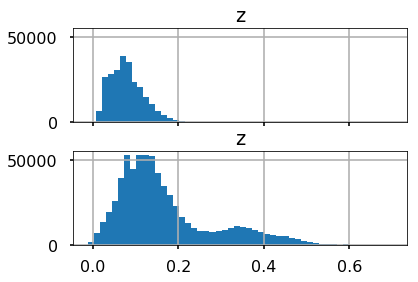

In [101]:
fig, axes = plt.subplots(2, sharex=True, sharey=True)
dr7_and_gz.hist('z', bins=50, ax=axes[0])
a = dr7_no_gz.hist('z', bins=50, ax=axes[1])

Basic catalogs (DR7 MPA-JHU for Heckman, NSA for Galaxy Zoo) disagree where galaxies are.

About (at most) half of this disagreement is because MPA_JHU is much deeper.

About (at least) half of this disagreement is unexplained

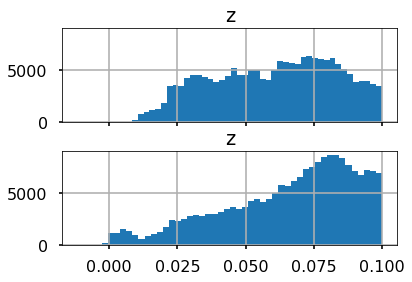

In [104]:
fig, axes = plt.subplots(2, sharex=True, sharey=True)
dr7_and_gz[dr7_and_gz['z'] < 0.1].hist('z', bins=50, ax=axes[0])
a = dr7_no_gz[dr7_no_gz['z'] < 0.1].hist('z', bins=50, ax=axes[1])

They disagree on galaxies which are very close (z < 0.012 or so). Otherwise, disagreement gradually increases with redshift - suggesting a centroid measurement error?  The matching radius I use is 10 arcseconds.

The DR13 tables here https://skyserver.sdss.org/dr13/en/help/docs/tabledesc.aspx include:
"SpecObjAll" - hopefully a complete joined (where possible) catalog between MPA and later work
"SpecObjInfo" - hopefully the MPA spectroscopic catalog, joinable to SpecObjAll with SpecObjID


http://home.strw.leidenuniv.nl/~jarle/SDSS/
https://wwwmpa.mpa-garching.mpg.de/SDSS/

In [81]:
heckman_nsa, heckman_only = match_galaxies_to_catalog_pandas(heckman, dr7)
print('LERG remaining: {} of {}'.format(heckman_nsa['lerg'].sum(), heckman['lerg'].sum()))
print('Galaxies remaining: {} of {}'.format(len(heckman_nsa), len(heckman)))

LERG remaining: 9863 of 9863
Galaxies remaining: 18286 of 18286


In [82]:
plot_catalog(heckman, filename='heckman_footprint')
plot_catalog(nsa, filename='nsa_footprint')
plot_catalog_overlap(heckman, nsa.sample(len(heckman)), legend=['heckman', 'nsa'], filename='nsa_heckman_overlap')
plot_catalog_overlap(heckman_nsa, heckman_only, legend=['matched', 'missed'], filename='nsa_heckman_matches')
# there are no heckman galaxies (red) outside the sdsss footprint(blue), as expected
# the mismatch happens within the footprint on ra/dec

/Data/repos/find_agn/shared_utilities.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  a_coords['catalog'] = legend[0]
/Data/repos/find_agn/shared_utilities.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  b_coords['catalog'] = legend[1]


In [84]:
# example_miss = heckman_only.iloc[5]
# ra = example_miss['ra']
# dec = example_miss['dec']
# print(ra)
# print(dec)
# print('http://www.legacysurvey.org/viewer?ra={}&dec={}&zoom=14&layer=decals-dr5'.format(ra, dec))

In [94]:
heckman_nsa_gz, no_gz = match_galaxies_to_catalog_pandas(heckman_nsa, galaxy_zoo)
print('LERG remaining: {} of {}'.format(heckman_nsa_gz['lerg'].sum(), heckman['lerg'].sum()))
print('Galaxies remaining: {} of {}'.format(len(heckman_nsa_gz), len(heckman['lerg'])))

LERG remaining: 3587 of 9863
Galaxies remaining: 6407 of 18286


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11f2de630>], dtype=object)

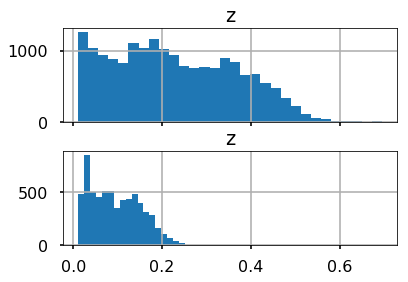

In [93]:
fig, axes = plt.subplots(2, sharex=True)
heckman_nsa.hist('z', bins=30, ax=axes[0])
heckman_nsa_gz.hist('z', bins=30, ax=axes[1])

In [ ]:
# heckman_decals, heckman_only = match_galaxies_to_catalog_pandas(heckman, joint_catalog[useful_nsa_columns].to_pandas())
# # TODO plot heckman_only
# print('LERG remaining: {} of {}'.format(heckman_decals['lerg'].sum(), heckman['lerg'].sum()))
# print('Galaxies remaining: {} of {}'.format(len(heckman_decals), len(heckman['lerg'])))

In [ ]:
# heckman_decals_gz, _ = match_galaxies_to_catalog_pandas(heckman_decals, galaxy_zoo)
# print('LERG remaining: {} of {}'.format(heckman_decals_gz['lerg'].sum(), heckman['lerg'].sum()))
# print('Galaxies remaining: {} of {}'.format(len(heckman_decals_gz), len(heckman['lerg'])))

In [11]:
print(heckman_nsa_gz.columns.values)

['id1' 'id2' 'id3' 'ra_subject' 'dec_subject' 'z' 's_nvss' 'radclas'
 's_first' 'off_first' 'rad_agn' 'main_sample' 'lerg' 'herg' 'best_match'
 'sky_separation' 'ra_subject' 'dec_subject' 'mag' 'petro_ba50'
 'petro_phi50' 'petro_ba90' 'petro_phi90' 'elpetro_mass' 'elpetro_phi'
 'elpetro_flux_r' 'elpetro_theta' 'elpetro_flux_f' 'elpetro_flux_n'
 'elpetro_flux_u' 'elpetro_flux_g' 'elpetro_flux_r.1' 'elpetro_flux_i'
 'elpetro_flux_z' 'dr7objid' 'ra' 'dec' 'rastring' 'decstring' 'sample'
 'gz2_class' 'total_classifications' 'total_votes'
 't01_smooth_or_features_a01_smooth_count'
 't01_smooth_or_features_a01_smooth_weight'
 't01_smooth_or_features_a01_smooth_fraction'
 't01_smooth_or_features_a01_smooth_weighted_fraction'
 't01_smooth_or_features_a01_smooth_debiased'
 't01_smooth_or_features_a01_smooth_flag'
 't01_smooth_or_features_a02_features_or_disk_count'
 't01_smooth_or_features_a02_features_or_disk_weight'
 't01_smooth_or_features_a02_features_or_disk_fraction'
 't01_smooth_or_featu

In [25]:
def get_agn_type(series):
    if series['herg'] == 1:
        return 'herg'
    elif series['lerg'] == 1:
        return 'lerg'
    else:
        return 'star-forming'
agn_types = ['herg', 'lerg', 'star-forming']

In [21]:
galaxies = heckman_nsa_gz.copy()
galaxies['p_bar'] = galaxies['t03_bar_a06_bar_debiased']
galaxies = galaxies.dropna(subset=['p_bar', 'petro_ba90'])
galaxies['agn_type'] = galaxies.apply(get_agn_type, axis=1)

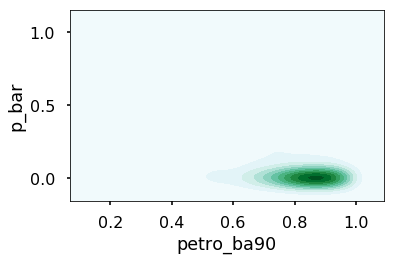

In [23]:
fig, ax = plt.subplots()
ax = sns.kdeplot(data=galaxies['petro_ba90'], data2=galaxies['p_bar'], ax=ax, shade=True)
fig.tight_layout()

74


/data/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/data/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/data/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/_kernel_base.py:514: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
/data/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1534: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/data/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1535: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min()

2564
2412


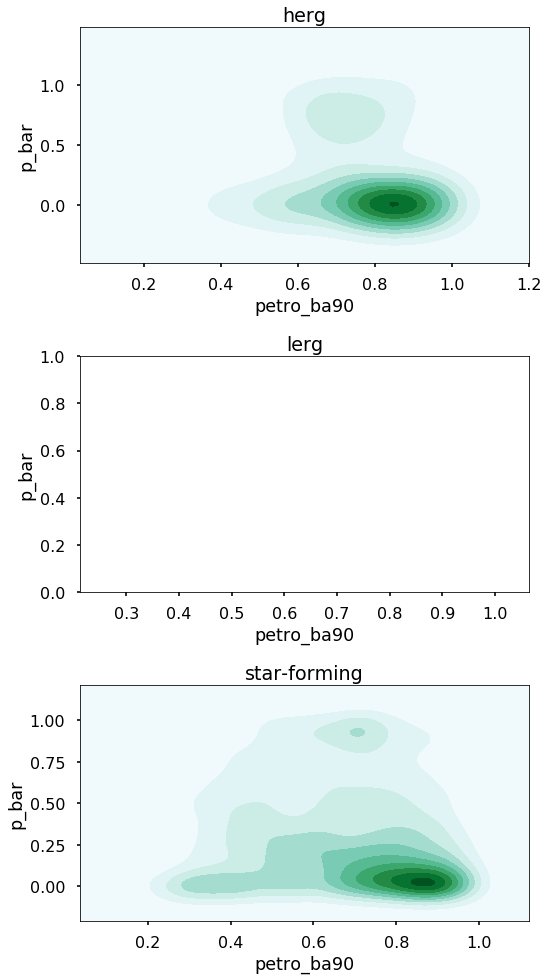

In [29]:
fig, axes = plt.subplots(3, figsize=(8, 14))
for n in range(3):
    agn_type = agn_types[n]
    selected_galaxies = galaxies[galaxies['agn_type'] == agn_type]
    ax = sns.kdeplot(data=selected_galaxies['petro_ba90'], data2=selected_galaxies['p_bar'], ax=axes[n], shade=True)
    ax.set_title(agn_type)
    print(len(selected_galaxies))
fig.tight_layout()

74
2564
2412


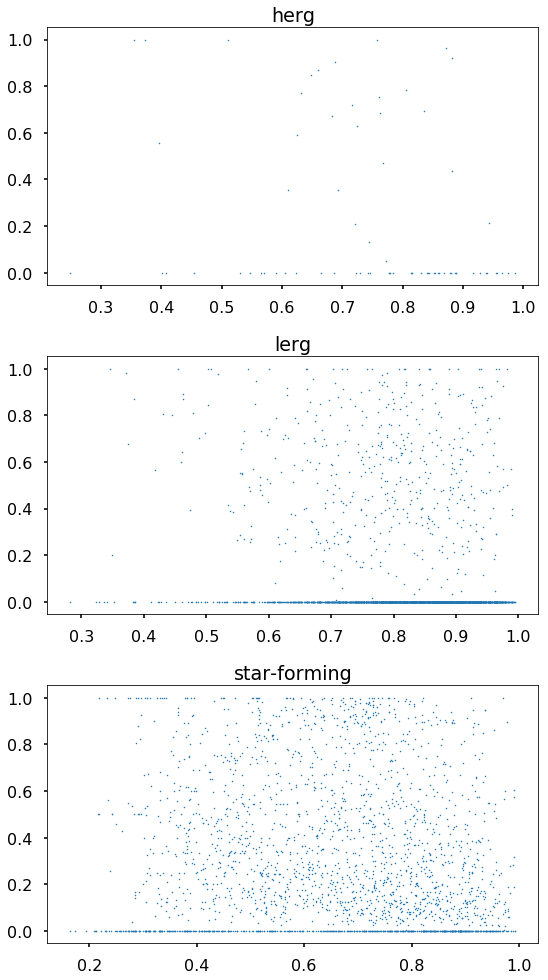

In [38]:
fig, axes = plt.subplots(3, figsize=(8, 14))
for n in range(3):
    ax = axes[n]
    agn_type = agn_types[n]
    selected_galaxies = galaxies[galaxies['agn_type'] == agn_type]
    ax.set_title(agn_type)
    ax.scatter(selected_galaxies['petro_ba90'], selected_galaxies['p_bar'], s=1.)
    print(len(selected_galaxies))
fig.tight_layout()